# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

## Objetivo:
La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
# Importar librerias necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

In [2]:
# Obtener los datos y definir la columna fechas como indice
df=pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])


In [3]:
# Ordenar por fecha
df.sort_index(inplace=True)

# Ver
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


## Análisis

In [4]:
# Revisar si hay valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# Revisar las caracteristicas estadisticas
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


### Conclusiones parciales
1. El dataset no viene con valores ausentes pero si fue necesario cambiar el tipo de dato de la columna fecha a datetime.

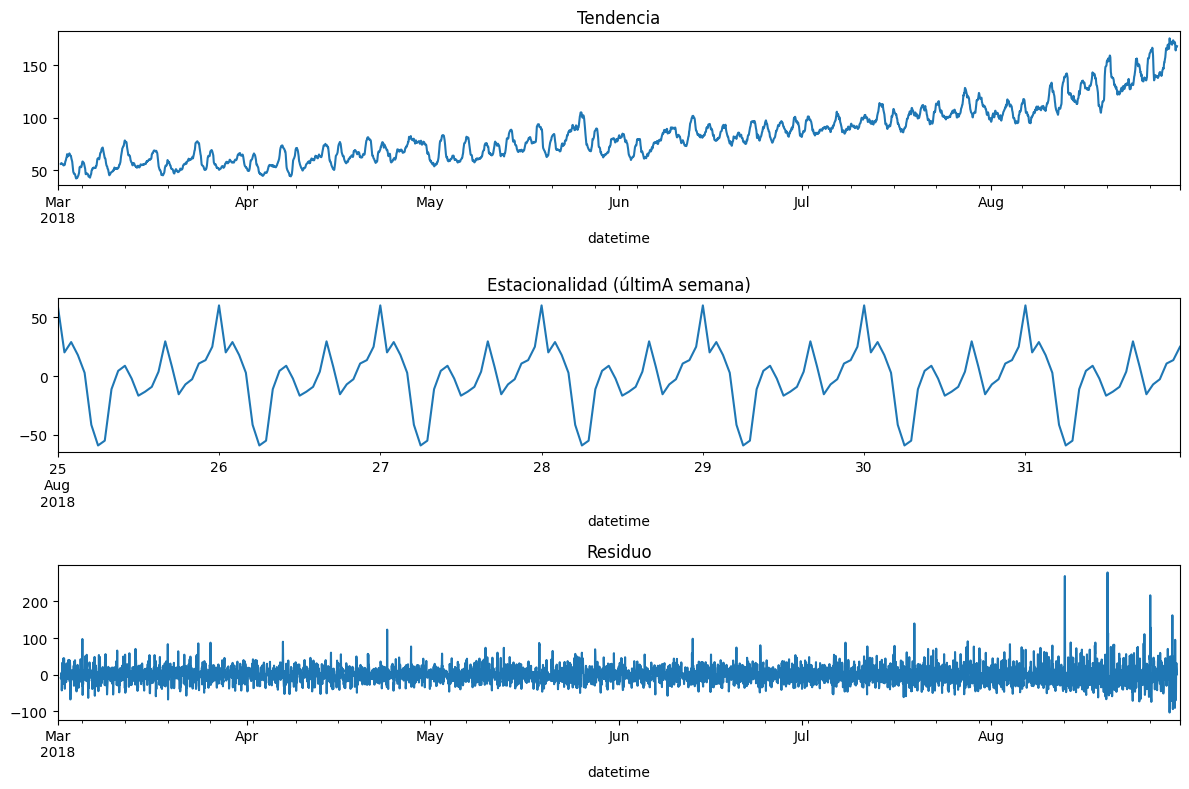

In [6]:
# Ver su tendencia y su estacionalidad del conjunto de datos (ver por día)
data1= df.resample('1H').sum()
decomposed = seasonal_decompose(data1)

plt.figure(figsize=(12,8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')

# La estacionalidad se verá solo por el último mes, para ver que dia son los mas demandados
plt.subplot(312)
decomposed.seasonal['2018-08-25':'2018-08-31'].plot(ax=plt.gca())
plt.title('Estacionalidad (últimA semana)')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuo')

plt.tight_layout()

<Figure size 2000x1500 with 0 Axes>

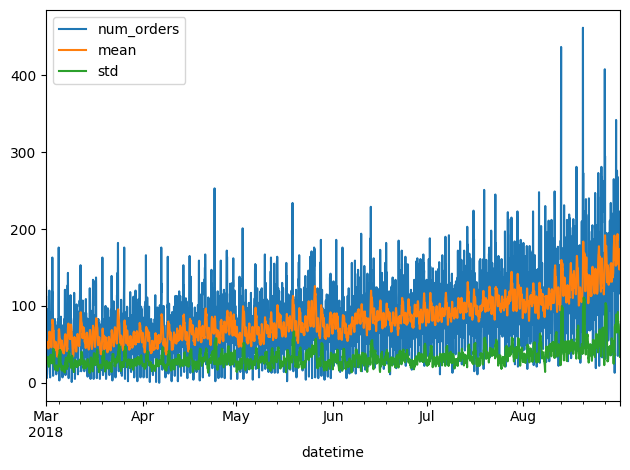

In [7]:
# Ver si la serie es estacionaria
plt.figure(figsize=(20,15))
data1['mean']= data1['num_orders'].rolling(15).mean()
data1['std']= data1['num_orders'].rolling(15).std()
data1.plot()
plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

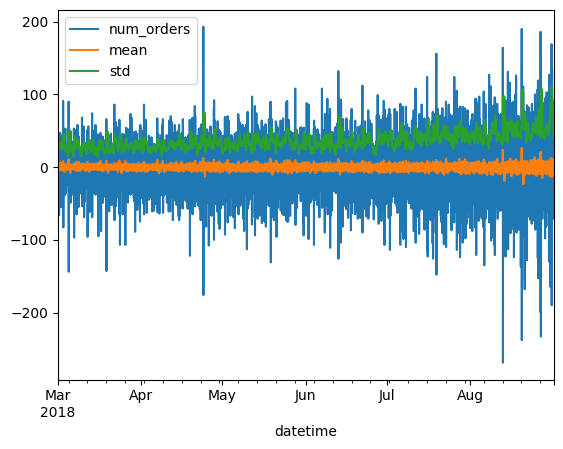

In [8]:
# Hacer 'mas estacionaria' a la serie
data2= data1-data1.shift()
data2['mean']= data2['num_orders'].rolling(15).mean()
data2['std']= data2['num_orders'].rolling(15).std()
data2.plot()

### Conclusiones parciales
1. Según los graficos, el numero de servicios realizados han aumentado durante el año.
2. Del gráfico estacionalidad, se puede divisar que en el último mes los dias donde hay más demanda son los viernes y los lunes.
3. La serie de tiempo original no es estacionaria, asi que con el fin de poder pronosticar la demanda de taxis, se aplicó diferencias de series temporales para hacerla estacionaria.


## Formación

In [9]:
# Crear una funcion para crear caracteristicas, colocar el desfase y calcular la media movil
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = (data['num_orders'].shift().rolling(rolling_mean_size).mean())


In [10]:
# Borrar las columans innecesarias
data1.drop(['mean','std'], axis=1, inplace=True)

# Ordernar el dataset
data1.sort_index(inplace=True)

In [11]:
# Aplicar la funcion al dataset
make_features(data1, 20,24)


In [12]:
# Separar el dataset en dos (entrenamiento y prueba)
train, test = train_test_split(data1, shuffle=False, test_size=0.1)

# Just in case, borrar las filas vacias del conjunto de entrenamiento
train=train.dropna()

In [13]:
# Separar por caracteristicas y objetivo
features_train= train.drop(['num_orders'], axis=1)
target_train= train['num_orders']

features_test= test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [14]:
# Ver features_train
features_train.head()

,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,2018,3,2,4,58.0,113.0,66.0,61.0,45.0,73.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.833333
2018-03-02 01:00:00,2018,3,2,4,90.0,58.0,113.0,66.0,61.0,45.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,55.416667
2018-03-02 02:00:00,2018,3,2,4,120.0,90.0,58.0,113.0,66.0,61.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,56.875000
2018-03-02 03:00:00,2018,3,2,4,75.0,120.0,90.0,58.0,113.0,66.0,...,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,57.041667
2018-03-02 04:00:00,2018,3,2,4,64.0,75.0,120.0,90.0,58.0,113.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,56.958333


### Regresion lineal

In [15]:
# Crear y entrenar un modelo de regresion lineal
model = LinearRegression()
model.fit(features_train, target_train)

# Predecir
pred_test = model.predict(features_test)

# Calcular RECM
recm = (mean_squared_error(target_test,pred_test))**0.5
print(f'El valor del recm es: {round(recm,2)}')

El valor del recm es: 46.6


### Random Forest

In [16]:
# Crear ibjeto random forest
rf = RandomForestRegressor()

# definimos una grilla para los parametros
param_grid={
            'n_estimators':[20,30,35],
            'max_depth' : [10,15]
}

# Crear el objeto gridsearch
grid_search1 = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=1)

# Ajusta el modelo a tus datos de entrenamiento
grid_search1.fit(features_train, target_train)

# Imprime los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search1.best_params_)

model_rf = grid_search1.best_estimator_

rf_prediction= model_rf.predict(features_test)

recm_rf = (mean_squared_error(target_test,rf_prediction))**0.5
recm_rf

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores hiperparámetros: {'max_depth': 15, 'n_estimators': 35}


49.92522175901836

### CATBOOST

In [17]:

# Define un diccionario de hiperparámetros que deseas ajustar
param_grid = {
    'iterations': [200,300,350],  # Número de iteraciones (árboles)
    'depth': [5,7],  # Profundidad máxima de los árboles
    'learning_rate': [0.1]  # Tasa de aprendizaje
}

# Crea un modelo de CatBoostRegressor
catboost = CatBoostRegressor(early_stopping_rounds=30)  

# Crea un objeto GridSearchCV con el modelo y el diccionario de hiperparámetros
grid_search2 = GridSearchCV(estimator=catboost, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=2, verbose=200)  



# Ajusta el modelo a tus datos de entrenamiento
grid_search2.fit(features_train, target_train)
eval_set= (features_train, target_train)

# Imprime los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search2.best_params_)

# Obtén el mejor modelo entrenado
best_catboost_model = grid_search2.best_estimator_


# Predicicon
cat_prediction=best_catboost_model.predict(features_test)

# Calcula el recm
recm_cb =mean_squared_error(target_test,cat_prediction,squared=False)
recm_cb

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2; 1/6] START depth=5, iterations=200, learning_rate=0.1..................
0:	learn: 38.1744399	total: 51.1ms	remaining: 10.2s
1:	learn: 37.3779128	total: 55.8ms	remaining: 5.52s
2:	learn: 36.5738278	total: 60.9ms	remaining: 4s
3:	learn: 35.8463239	total: 65.8ms	remaining: 3.22s
4:	learn: 35.2517653	total: 70.3ms	remaining: 2.74s
5:	learn: 34.8343883	total: 74.8ms	remaining: 2.42s
6:	learn: 34.3234850	total: 79.4ms	remaining: 2.19s
7:	learn: 33.9406726	total: 84.4ms	remaining: 2.03s
8:	learn: 33.5514838	total: 89ms	remaining: 1.89s
9:	learn: 33.1465517	total: 93.6ms	remaining: 1.78s
10:	learn: 32.8110061	total: 98.3ms	remaining: 1.69s
11:	learn: 32.4336439	total: 103ms	remaining: 1.61s
12:	learn: 32.0865740	total: 107ms	remaining: 1.55s
13:	learn: 31.7909643	total: 112ms	remaining: 1.49s
14:	learn: 31.5332609	total: 116ms	remaining: 1.44s
15:	learn: 31.3375067	total: 121ms	remaining: 1.39s
16:	learn: 31.1397450	total: 12

174:	learn: 19.7350493	total: 860ms	remaining: 123ms
175:	learn: 19.6974566	total: 865ms	remaining: 118ms
176:	learn: 19.6799238	total: 869ms	remaining: 113ms
177:	learn: 19.6399896	total: 873ms	remaining: 108ms
178:	learn: 19.5923452	total: 878ms	remaining: 103ms
179:	learn: 19.5572571	total: 882ms	remaining: 98.1ms
180:	learn: 19.5350423	total: 888ms	remaining: 93.2ms
181:	learn: 19.5013882	total: 892ms	remaining: 88.2ms
182:	learn: 19.4720403	total: 897ms	remaining: 83.3ms
183:	learn: 19.4260500	total: 909ms	remaining: 79.1ms
184:	learn: 19.3721212	total: 914ms	remaining: 74.1ms
185:	learn: 19.3395700	total: 919ms	remaining: 69.1ms
186:	learn: 19.3097481	total: 923ms	remaining: 64.2ms
187:	learn: 19.2895501	total: 928ms	remaining: 59.2ms
188:	learn: 19.2673781	total: 932ms	remaining: 54.2ms
189:	learn: 19.2176197	total: 936ms	remaining: 49.3ms
190:	learn: 19.1891725	total: 941ms	remaining: 44.3ms
191:	learn: 19.1762757	total: 946ms	remaining: 39.4ms
192:	learn: 19.1337454	total: 951

153:	learn: 15.3794972	total: 595ms	remaining: 178ms
154:	learn: 15.3229142	total: 603ms	remaining: 175ms
155:	learn: 15.2872888	total: 607ms	remaining: 171ms
156:	learn: 15.2495542	total: 611ms	remaining: 167ms
157:	learn: 15.2431277	total: 615ms	remaining: 163ms
158:	learn: 15.1986885	total: 619ms	remaining: 160ms
159:	learn: 15.1550426	total: 623ms	remaining: 156ms
160:	learn: 15.1524157	total: 626ms	remaining: 152ms
161:	learn: 15.1062279	total: 630ms	remaining: 148ms
162:	learn: 15.0751114	total: 634ms	remaining: 144ms
163:	learn: 15.0576455	total: 638ms	remaining: 140ms
164:	learn: 15.0553181	total: 641ms	remaining: 136ms
165:	learn: 15.0380936	total: 645ms	remaining: 132ms
166:	learn: 14.9974670	total: 649ms	remaining: 128ms
167:	learn: 14.9705470	total: 653ms	remaining: 124ms
168:	learn: 14.9339014	total: 657ms	remaining: 120ms
169:	learn: 14.9316436	total: 660ms	remaining: 117ms
170:	learn: 14.9295055	total: 664ms	remaining: 113ms
171:	learn: 14.8837881	total: 668ms	remaining:

113:	learn: 22.7649632	total: 535ms	remaining: 872ms
114:	learn: 22.7202995	total: 540ms	remaining: 868ms
115:	learn: 22.6643617	total: 544ms	remaining: 863ms
116:	learn: 22.6098565	total: 548ms	remaining: 858ms
117:	learn: 22.5525664	total: 553ms	remaining: 853ms
118:	learn: 22.4880163	total: 557ms	remaining: 848ms
119:	learn: 22.4145239	total: 562ms	remaining: 843ms
120:	learn: 22.3537826	total: 566ms	remaining: 838ms
121:	learn: 22.2946952	total: 571ms	remaining: 833ms
122:	learn: 22.2880416	total: 575ms	remaining: 828ms
123:	learn: 22.2022398	total: 580ms	remaining: 823ms
124:	learn: 22.1519339	total: 585ms	remaining: 819ms
125:	learn: 22.1007258	total: 589ms	remaining: 814ms
126:	learn: 22.0242308	total: 598ms	remaining: 815ms
127:	learn: 21.9666823	total: 603ms	remaining: 810ms
128:	learn: 21.9157170	total: 607ms	remaining: 805ms
129:	learn: 21.8385872	total: 612ms	remaining: 800ms
130:	learn: 21.7760880	total: 616ms	remaining: 795ms
131:	learn: 21.6817559	total: 621ms	remaining:

283:	learn: 15.9883157	total: 1.33s	remaining: 75ms
284:	learn: 15.9388997	total: 1.33s	remaining: 70.3ms
285:	learn: 15.8990269	total: 1.34s	remaining: 65.6ms
286:	learn: 15.8859493	total: 1.34s	remaining: 60.9ms
287:	learn: 15.8651997	total: 1.35s	remaining: 56.2ms
288:	learn: 15.8335401	total: 1.35s	remaining: 51.5ms
289:	learn: 15.8195012	total: 1.36s	remaining: 46.8ms
290:	learn: 15.7984370	total: 1.36s	remaining: 42.1ms
291:	learn: 15.7666137	total: 1.37s	remaining: 37.5ms
292:	learn: 15.7206497	total: 1.37s	remaining: 32.8ms
293:	learn: 15.7014215	total: 1.38s	remaining: 28.1ms
294:	learn: 15.6797661	total: 1.38s	remaining: 23.5ms
295:	learn: 15.6743422	total: 1.39s	remaining: 18.8ms
296:	learn: 15.6406939	total: 1.39s	remaining: 14.1ms
297:	learn: 15.6113095	total: 1.4s	remaining: 9.39ms
298:	learn: 15.5997765	total: 1.4s	remaining: 4.69ms
299:	learn: 15.5817647	total: 1.41s	remaining: 0us
[CV 1/2; 2/6] END depth=5, iterations=300, learning_rate=0.1; total time=   1.6s
[CV 2/2;

153:	learn: 15.3794972	total: 606ms	remaining: 575ms
154:	learn: 15.3229142	total: 611ms	remaining: 571ms
155:	learn: 15.2872888	total: 614ms	remaining: 567ms
156:	learn: 15.2495542	total: 618ms	remaining: 563ms
157:	learn: 15.2431277	total: 622ms	remaining: 559ms
158:	learn: 15.1986885	total: 626ms	remaining: 555ms
159:	learn: 15.1550426	total: 630ms	remaining: 552ms
160:	learn: 15.1524157	total: 634ms	remaining: 548ms
161:	learn: 15.1062279	total: 638ms	remaining: 544ms
162:	learn: 15.0751114	total: 642ms	remaining: 540ms
163:	learn: 15.0576455	total: 646ms	remaining: 536ms
164:	learn: 15.0553181	total: 649ms	remaining: 531ms
165:	learn: 15.0380936	total: 653ms	remaining: 527ms
166:	learn: 14.9974670	total: 657ms	remaining: 524ms
167:	learn: 14.9705470	total: 661ms	remaining: 520ms
168:	learn: 14.9339014	total: 665ms	remaining: 516ms
169:	learn: 14.9316436	total: 669ms	remaining: 512ms
170:	learn: 14.9295055	total: 673ms	remaining: 508ms
171:	learn: 14.8837881	total: 677ms	remaining:

26:	learn: 29.2463795	total: 137ms	remaining: 1.63s
27:	learn: 29.1489005	total: 144ms	remaining: 1.65s
28:	learn: 28.9756079	total: 148ms	remaining: 1.64s
29:	learn: 28.7785175	total: 153ms	remaining: 1.63s
30:	learn: 28.6033620	total: 157ms	remaining: 1.62s
31:	learn: 28.4356096	total: 162ms	remaining: 1.61s
32:	learn: 28.3188085	total: 166ms	remaining: 1.6s
33:	learn: 28.2524564	total: 171ms	remaining: 1.59s
34:	learn: 28.1144833	total: 175ms	remaining: 1.58s
35:	learn: 27.9797202	total: 180ms	remaining: 1.57s
36:	learn: 27.8325496	total: 185ms	remaining: 1.56s
37:	learn: 27.7021904	total: 189ms	remaining: 1.55s
38:	learn: 27.6270602	total: 194ms	remaining: 1.55s
39:	learn: 27.5015063	total: 198ms	remaining: 1.54s
40:	learn: 27.3965209	total: 203ms	remaining: 1.53s
41:	learn: 27.3624197	total: 207ms	remaining: 1.52s
42:	learn: 27.2492726	total: 212ms	remaining: 1.51s
43:	learn: 27.1062404	total: 216ms	remaining: 1.5s
44:	learn: 27.0088927	total: 226ms	remaining: 1.53s
45:	learn: 26.

196:	learn: 18.9866235	total: 930ms	remaining: 723ms
197:	learn: 18.9369561	total: 935ms	remaining: 718ms
198:	learn: 18.8923604	total: 940ms	remaining: 713ms
199:	learn: 18.8596733	total: 944ms	remaining: 708ms
200:	learn: 18.8106539	total: 949ms	remaining: 704ms
201:	learn: 18.7926988	total: 954ms	remaining: 699ms
202:	learn: 18.7567950	total: 958ms	remaining: 694ms
203:	learn: 18.7195100	total: 962ms	remaining: 689ms
204:	learn: 18.6735985	total: 967ms	remaining: 684ms
205:	learn: 18.6466637	total: 971ms	remaining: 679ms
206:	learn: 18.6142303	total: 976ms	remaining: 674ms
207:	learn: 18.5756146	total: 980ms	remaining: 669ms
208:	learn: 18.5459769	total: 985ms	remaining: 664ms
209:	learn: 18.5182486	total: 989ms	remaining: 660ms
210:	learn: 18.4885375	total: 994ms	remaining: 655ms
211:	learn: 18.4492784	total: 998ms	remaining: 650ms
212:	learn: 18.4304717	total: 1s	remaining: 645ms
213:	learn: 18.3894101	total: 1.01s	remaining: 643ms
214:	learn: 18.3448066	total: 1.02s	remaining: 63

0:	learn: 31.0565620	total: 4.02ms	remaining: 1.4s
1:	learn: 30.2581610	total: 8.45ms	remaining: 1.47s
2:	learn: 29.5195882	total: 12.3ms	remaining: 1.42s
3:	learn: 28.8884287	total: 16ms	remaining: 1.38s
4:	learn: 28.2460307	total: 19.9ms	remaining: 1.37s
5:	learn: 27.7432641	total: 23.6ms	remaining: 1.35s
6:	learn: 27.2808676	total: 27.6ms	remaining: 1.35s
7:	learn: 26.8345145	total: 31.5ms	remaining: 1.35s
8:	learn: 26.3983375	total: 35.4ms	remaining: 1.34s
9:	learn: 26.0853822	total: 39.1ms	remaining: 1.33s
10:	learn: 25.7091710	total: 42.9ms	remaining: 1.32s
11:	learn: 25.3791050	total: 46.6ms	remaining: 1.31s
12:	learn: 25.0967830	total: 50.4ms	remaining: 1.31s
13:	learn: 24.8477086	total: 54.1ms	remaining: 1.3s
14:	learn: 24.5779473	total: 58.1ms	remaining: 1.3s
15:	learn: 24.3717641	total: 62ms	remaining: 1.29s
16:	learn: 24.1669753	total: 65.9ms	remaining: 1.29s
17:	learn: 23.9044564	total: 69.7ms	remaining: 1.28s
18:	learn: 23.7336592	total: 73.5ms	remaining: 1.28s
19:	learn:

203:	learn: 13.9843394	total: 801ms	remaining: 573ms
204:	learn: 13.9824185	total: 805ms	remaining: 569ms
205:	learn: 13.9464238	total: 809ms	remaining: 565ms
206:	learn: 13.9198985	total: 812ms	remaining: 561ms
207:	learn: 13.9077970	total: 816ms	remaining: 557ms
208:	learn: 13.8664944	total: 820ms	remaining: 553ms
209:	learn: 13.8568379	total: 824ms	remaining: 549ms
210:	learn: 13.8549858	total: 831ms	remaining: 548ms
211:	learn: 13.8203175	total: 835ms	remaining: 544ms
212:	learn: 13.7964266	total: 839ms	remaining: 540ms
213:	learn: 13.7779175	total: 843ms	remaining: 536ms
214:	learn: 13.7523246	total: 847ms	remaining: 532ms
215:	learn: 13.7457009	total: 851ms	remaining: 528ms
216:	learn: 13.7184106	total: 854ms	remaining: 524ms
217:	learn: 13.7013757	total: 858ms	remaining: 520ms
218:	learn: 13.6728225	total: 862ms	remaining: 515ms
219:	learn: 13.6573635	total: 865ms	remaining: 511ms
220:	learn: 13.6272803	total: 869ms	remaining: 507ms
221:	learn: 13.6016469	total: 873ms	remaining:

9:	learn: 32.2949398	total: 127ms	remaining: 2.42s
10:	learn: 31.9052694	total: 140ms	remaining: 2.4s
11:	learn: 31.4764263	total: 152ms	remaining: 2.38s
12:	learn: 31.1480886	total: 165ms	remaining: 2.37s
13:	learn: 30.7547542	total: 178ms	remaining: 2.36s
14:	learn: 30.4507702	total: 190ms	remaining: 2.34s
15:	learn: 30.1281409	total: 202ms	remaining: 2.32s
16:	learn: 29.7425865	total: 218ms	remaining: 2.35s
17:	learn: 29.4746417	total: 231ms	remaining: 2.34s
18:	learn: 29.1800407	total: 243ms	remaining: 2.32s
19:	learn: 28.8957832	total: 256ms	remaining: 2.3s
20:	learn: 28.5739974	total: 268ms	remaining: 2.28s
21:	learn: 28.4769303	total: 280ms	remaining: 2.27s
22:	learn: 28.2687220	total: 293ms	remaining: 2.25s
23:	learn: 28.0607346	total: 306ms	remaining: 2.25s
24:	learn: 27.8466210	total: 318ms	remaining: 2.23s
25:	learn: 27.6126708	total: 331ms	remaining: 2.21s
26:	learn: 27.4184933	total: 344ms	remaining: 2.21s
27:	learn: 27.3903318	total: 358ms	remaining: 2.2s
28:	learn: 27.22

170:	learn: 15.1989604	total: 2.17s	remaining: 368ms
171:	learn: 15.1318312	total: 2.19s	remaining: 356ms
172:	learn: 15.1291644	total: 2.2s	remaining: 344ms
173:	learn: 15.0927625	total: 2.21s	remaining: 331ms
174:	learn: 15.0106946	total: 2.23s	remaining: 318ms
175:	learn: 14.9694944	total: 2.24s	remaining: 305ms
176:	learn: 14.9416916	total: 2.25s	remaining: 292ms
177:	learn: 14.8823280	total: 2.26s	remaining: 280ms
178:	learn: 14.8040149	total: 2.27s	remaining: 267ms
179:	learn: 14.7575293	total: 2.29s	remaining: 254ms
180:	learn: 14.7011471	total: 2.3s	remaining: 241ms
181:	learn: 14.6421861	total: 2.31s	remaining: 229ms
182:	learn: 14.6179563	total: 2.33s	remaining: 216ms
183:	learn: 14.5741481	total: 2.34s	remaining: 203ms
184:	learn: 14.5079440	total: 2.35s	remaining: 191ms
185:	learn: 14.4504008	total: 2.36s	remaining: 178ms
186:	learn: 14.4261463	total: 2.38s	remaining: 165ms
187:	learn: 14.3905639	total: 2.39s	remaining: 153ms
188:	learn: 14.3606657	total: 2.4s	remaining: 14

125:	learn: 13.5228677	total: 1.34s	remaining: 788ms
126:	learn: 13.4756892	total: 1.35s	remaining: 778ms
127:	learn: 13.4283028	total: 1.36s	remaining: 767ms
128:	learn: 13.4053725	total: 1.37s	remaining: 756ms
129:	learn: 13.3602806	total: 1.38s	remaining: 745ms
130:	learn: 13.3163472	total: 1.39s	remaining: 734ms
131:	learn: 13.2647752	total: 1.41s	remaining: 724ms
132:	learn: 13.1896842	total: 1.42s	remaining: 715ms
133:	learn: 13.1713804	total: 1.43s	remaining: 704ms
134:	learn: 13.1685620	total: 1.44s	remaining: 693ms
135:	learn: 13.0951392	total: 1.45s	remaining: 683ms
136:	learn: 13.0572663	total: 1.46s	remaining: 672ms
137:	learn: 12.9970636	total: 1.47s	remaining: 661ms
138:	learn: 12.9596281	total: 1.48s	remaining: 651ms
139:	learn: 12.9197318	total: 1.49s	remaining: 640ms
140:	learn: 12.8912851	total: 1.5s	remaining: 629ms
141:	learn: 12.8758529	total: 1.51s	remaining: 618ms
142:	learn: 12.8129478	total: 1.52s	remaining: 608ms
143:	learn: 12.7817629	total: 1.53s	remaining: 

87:	learn: 21.1002743	total: 1.17s	remaining: 2.83s
88:	learn: 21.0934807	total: 1.18s	remaining: 2.79s
89:	learn: 20.9921950	total: 1.19s	remaining: 2.77s
90:	learn: 20.8880999	total: 1.2s	remaining: 2.76s
91:	learn: 20.7642212	total: 1.22s	remaining: 2.75s
92:	learn: 20.6596337	total: 1.23s	remaining: 2.74s
93:	learn: 20.5463884	total: 1.24s	remaining: 2.73s
94:	learn: 20.4867984	total: 1.26s	remaining: 2.71s
95:	learn: 20.4150337	total: 1.27s	remaining: 2.7s
96:	learn: 20.4023703	total: 1.28s	remaining: 2.69s
97:	learn: 20.2949305	total: 1.3s	remaining: 2.67s
98:	learn: 20.2006185	total: 1.31s	remaining: 2.66s
99:	learn: 20.1188259	total: 1.32s	remaining: 2.64s
100:	learn: 20.0694017	total: 1.33s	remaining: 2.63s
101:	learn: 19.9941026	total: 1.35s	remaining: 2.62s
102:	learn: 19.9120082	total: 1.36s	remaining: 2.6s
103:	learn: 19.8725921	total: 1.37s	remaining: 2.59s
104:	learn: 19.7735090	total: 1.38s	remaining: 2.57s
105:	learn: 19.7047510	total: 1.4s	remaining: 2.56s
106:	learn:

246:	learn: 11.9651093	total: 3.23s	remaining: 694ms
247:	learn: 11.9410845	total: 3.25s	remaining: 681ms
248:	learn: 11.9014377	total: 3.26s	remaining: 668ms
249:	learn: 11.8694342	total: 3.27s	remaining: 654ms
250:	learn: 11.8395225	total: 3.28s	remaining: 641ms
251:	learn: 11.7943265	total: 3.3s	remaining: 629ms
252:	learn: 11.7643547	total: 3.31s	remaining: 616ms
253:	learn: 11.7316986	total: 3.33s	remaining: 603ms
254:	learn: 11.6913336	total: 3.34s	remaining: 589ms
255:	learn: 11.6330715	total: 3.35s	remaining: 576ms
256:	learn: 11.6193901	total: 3.36s	remaining: 563ms
257:	learn: 11.5761404	total: 3.38s	remaining: 550ms
258:	learn: 11.5423239	total: 3.39s	remaining: 537ms
259:	learn: 11.5327034	total: 3.4s	remaining: 523ms
260:	learn: 11.4937097	total: 3.41s	remaining: 510ms
261:	learn: 11.4366394	total: 3.43s	remaining: 497ms
262:	learn: 11.4116901	total: 3.44s	remaining: 484ms
263:	learn: 11.3768847	total: 3.45s	remaining: 471ms
264:	learn: 11.3260690	total: 3.46s	remaining: 4

116:	learn: 13.9137905	total: 1.23s	remaining: 1.92s
117:	learn: 13.8218966	total: 1.24s	remaining: 1.92s
118:	learn: 13.8186980	total: 1.25s	remaining: 1.9s
119:	learn: 13.7754115	total: 1.26s	remaining: 1.89s
120:	learn: 13.7292276	total: 1.27s	remaining: 1.88s
121:	learn: 13.6622728	total: 1.28s	remaining: 1.87s
122:	learn: 13.6590798	total: 1.29s	remaining: 1.86s
123:	learn: 13.6557476	total: 1.3s	remaining: 1.85s
124:	learn: 13.5694530	total: 1.31s	remaining: 1.84s
125:	learn: 13.5228677	total: 1.32s	remaining: 1.83s
126:	learn: 13.4756892	total: 1.33s	remaining: 1.82s
127:	learn: 13.4283028	total: 1.34s	remaining: 1.81s
128:	learn: 13.4053725	total: 1.35s	remaining: 1.8s
129:	learn: 13.3602806	total: 1.37s	remaining: 1.79s
130:	learn: 13.3163472	total: 1.38s	remaining: 1.77s
131:	learn: 13.2647752	total: 1.39s	remaining: 1.76s
132:	learn: 13.1896842	total: 1.4s	remaining: 1.75s
133:	learn: 13.1713804	total: 1.41s	remaining: 1.74s
134:	learn: 13.1685620	total: 1.42s	remaining: 1.7

287:	learn: 8.2419643	total: 3.04s	remaining: 127ms
288:	learn: 8.2377459	total: 3.05s	remaining: 116ms
289:	learn: 8.2215986	total: 3.06s	remaining: 105ms
290:	learn: 8.2008618	total: 3.07s	remaining: 94.9ms
291:	learn: 8.1890450	total: 3.08s	remaining: 84.4ms
292:	learn: 8.1656881	total: 3.09s	remaining: 73.8ms
293:	learn: 8.1446066	total: 3.1s	remaining: 63.3ms
294:	learn: 8.1238388	total: 3.11s	remaining: 52.8ms
295:	learn: 8.0923097	total: 3.13s	remaining: 42.2ms
296:	learn: 8.0773028	total: 3.13s	remaining: 31.7ms
297:	learn: 8.0504493	total: 3.15s	remaining: 21.1ms
298:	learn: 8.0117061	total: 3.16s	remaining: 10.6ms
299:	learn: 7.9858463	total: 3.17s	remaining: 0us
[CV 2/2; 5/6] END depth=7, iterations=300, learning_rate=0.1; total time=   3.3s
[CV 1/2; 6/6] START depth=7, iterations=350, learning_rate=0.1..................
0:	learn: 38.1099434	total: 12.6ms	remaining: 4.4s
1:	learn: 37.2638097	total: 25.5ms	remaining: 4.43s
2:	learn: 36.3526429	total: 37.8ms	remaining: 4.37s
3

145:	learn: 16.6876277	total: 1.85s	remaining: 2.59s
146:	learn: 16.6011325	total: 1.87s	remaining: 2.58s
147:	learn: 16.5382887	total: 1.88s	remaining: 2.57s
148:	learn: 16.4803651	total: 1.9s	remaining: 2.56s
149:	learn: 16.3874161	total: 1.91s	remaining: 2.55s
150:	learn: 16.3374817	total: 1.92s	remaining: 2.54s
151:	learn: 16.2652348	total: 1.94s	remaining: 2.52s
152:	learn: 16.2016669	total: 1.95s	remaining: 2.51s
153:	learn: 16.1372743	total: 1.96s	remaining: 2.5s
154:	learn: 16.0423710	total: 1.97s	remaining: 2.48s
155:	learn: 16.0018423	total: 1.99s	remaining: 2.47s
156:	learn: 15.9601123	total: 2s	remaining: 2.46s
157:	learn: 15.8925340	total: 2.01s	remaining: 2.44s
158:	learn: 15.8632326	total: 2.02s	remaining: 2.43s
159:	learn: 15.8119648	total: 2.03s	remaining: 2.42s
160:	learn: 15.7831461	total: 2.05s	remaining: 2.4s
161:	learn: 15.7490810	total: 2.06s	remaining: 2.39s
162:	learn: 15.7153324	total: 2.07s	remaining: 2.38s
163:	learn: 15.6698196	total: 2.08s	remaining: 2.36s

304:	learn: 10.0303282	total: 3.91s	remaining: 577ms
305:	learn: 9.9974158	total: 3.92s	remaining: 564ms
306:	learn: 9.9682985	total: 3.94s	remaining: 551ms
307:	learn: 9.9316418	total: 3.95s	remaining: 538ms
308:	learn: 9.9066541	total: 3.96s	remaining: 526ms
309:	learn: 9.8856144	total: 3.98s	remaining: 513ms
310:	learn: 9.8577688	total: 3.99s	remaining: 501ms
311:	learn: 9.8339679	total: 4s	remaining: 488ms
312:	learn: 9.8212995	total: 4.02s	remaining: 475ms
313:	learn: 9.7980944	total: 4.03s	remaining: 462ms
314:	learn: 9.7738079	total: 4.04s	remaining: 449ms
315:	learn: 9.7356932	total: 4.05s	remaining: 436ms
316:	learn: 9.7097959	total: 4.07s	remaining: 423ms
317:	learn: 9.6856874	total: 4.08s	remaining: 410ms
318:	learn: 9.6683836	total: 4.09s	remaining: 398ms
319:	learn: 9.6374208	total: 4.1s	remaining: 385ms
320:	learn: 9.6109784	total: 4.12s	remaining: 372ms
321:	learn: 9.5920776	total: 4.13s	remaining: 359ms
322:	learn: 9.5733996	total: 4.14s	remaining: 346ms
323:	learn: 9.5

126:	learn: 13.4756892	total: 1.35s	remaining: 2.37s
127:	learn: 13.4283028	total: 1.36s	remaining: 2.36s
128:	learn: 13.4053725	total: 1.37s	remaining: 2.35s
129:	learn: 13.3602806	total: 1.38s	remaining: 2.34s
130:	learn: 13.3163472	total: 1.39s	remaining: 2.33s
131:	learn: 13.2647752	total: 1.4s	remaining: 2.32s
132:	learn: 13.1896842	total: 1.42s	remaining: 2.31s
133:	learn: 13.1713804	total: 1.43s	remaining: 2.3s
134:	learn: 13.1685620	total: 1.44s	remaining: 2.29s
135:	learn: 13.0951392	total: 1.45s	remaining: 2.28s
136:	learn: 13.0572663	total: 1.46s	remaining: 2.27s
137:	learn: 12.9970636	total: 1.47s	remaining: 2.26s
138:	learn: 12.9596281	total: 1.48s	remaining: 2.25s
139:	learn: 12.9197318	total: 1.49s	remaining: 2.23s
140:	learn: 12.8912851	total: 1.5s	remaining: 2.22s
141:	learn: 12.8758529	total: 1.51s	remaining: 2.21s
142:	learn: 12.8129478	total: 1.52s	remaining: 2.2s
143:	learn: 12.7817629	total: 1.53s	remaining: 2.19s
144:	learn: 12.7790768	total: 1.54s	remaining: 2.1

298:	learn: 8.0117061	total: 3.16s	remaining: 539ms
299:	learn: 7.9858463	total: 3.17s	remaining: 529ms
300:	learn: 7.9611399	total: 3.18s	remaining: 518ms
301:	learn: 7.9368337	total: 3.2s	remaining: 508ms
302:	learn: 7.9155822	total: 3.21s	remaining: 497ms
303:	learn: 7.9022604	total: 3.22s	remaining: 487ms
304:	learn: 7.8759134	total: 3.23s	remaining: 476ms
305:	learn: 7.8550450	total: 3.24s	remaining: 465ms
306:	learn: 7.8203942	total: 3.25s	remaining: 455ms
307:	learn: 7.8092456	total: 3.26s	remaining: 444ms
308:	learn: 7.7879216	total: 3.27s	remaining: 434ms
309:	learn: 7.7670189	total: 3.28s	remaining: 423ms
310:	learn: 7.7500523	total: 3.29s	remaining: 412ms
311:	learn: 7.7344713	total: 3.3s	remaining: 402ms
312:	learn: 7.7146523	total: 3.31s	remaining: 391ms
313:	learn: 7.6946520	total: 3.32s	remaining: 380ms
314:	learn: 7.6826344	total: 3.33s	remaining: 370ms
315:	learn: 7.6461681	total: 3.34s	remaining: 359ms
316:	learn: 7.6274881	total: 3.35s	remaining: 349ms
317:	learn: 7.

105:	learn: 20.0431360	total: 1.46s	remaining: 1.29s
106:	learn: 19.9766803	total: 1.47s	remaining: 1.28s
107:	learn: 19.9336547	total: 1.48s	remaining: 1.26s
108:	learn: 19.8969436	total: 1.5s	remaining: 1.25s
109:	learn: 19.8218066	total: 1.51s	remaining: 1.23s
110:	learn: 19.7764830	total: 1.52s	remaining: 1.22s
111:	learn: 19.7086025	total: 1.54s	remaining: 1.21s
112:	learn: 19.6353604	total: 1.55s	remaining: 1.2s
113:	learn: 19.6307997	total: 1.57s	remaining: 1.18s
114:	learn: 19.5581801	total: 1.58s	remaining: 1.17s
115:	learn: 19.5539344	total: 1.59s	remaining: 1.15s
116:	learn: 19.5004883	total: 1.61s	remaining: 1.14s
117:	learn: 19.4929356	total: 1.62s	remaining: 1.13s
118:	learn: 19.4407692	total: 1.63s	remaining: 1.11s
119:	learn: 19.4060848	total: 1.65s	remaining: 1.1s
120:	learn: 19.4024370	total: 1.66s	remaining: 1.08s
121:	learn: 19.3576765	total: 1.67s	remaining: 1.07s
122:	learn: 19.2938376	total: 1.69s	remaining: 1.06s
123:	learn: 19.2260673	total: 1.7s	remaining: 1.0

49.66108250756234

## Prueba

In [18]:
print('Resultado de la regresion lineal')
print('recm: ', round(recm,2))
print()
print('Resultado del random forest')
print('recm. ',round(recm_rf,2))
print()
print('Resultado del Catboost')
print('recm: ',round(recm_cb,2) )

Resultado de la regresion lineal
recm:  46.6

Resultado del random forest
recm.  49.93

Resultado del Catboost
recm:  49.66


## Conclusiones

1. La serie temporal original no es estatica y se tuvo que utilizar metodologias para hacerla 'más estática'.
2. En este caso, el modelo construido con regresion lineal resultó ser las que más se adecuada.
3. El RECM para el modelo seleccionado es menor a 48.